In [27]:
import requests
from pathlib import Path
from datetime import datetime
import time
import csv
import re, json
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import os


### Verify if the book is already downloaded

In [28]:
CTRL = Path("control")
CTRL.mkdir(exist_ok=True)

LOG_CSV   = CTRL / "control_log.csv"
DOWN_TXT  = CTRL / "downloaded_books.txt"

START_MARKER = "*** START OF THE PROJECT GUTENBERG EBOOK"
END_MARKER   = "*** END OF THE PROJECT GUTENBERG EBOOK"

def already_downloaded(book_id: int) -> bool: 
    return DOWN_TXT.exists() and str(book_id) in DOWN_TXT.read_text(encoding="utf-8").splitlines()

def download_book(book_id: int, base: str = "datalake") -> tuple[Path, Path] | None:
    if already_downloaded(book_id):
        print(f"[SKIP] {book_id} was already downloaded")
        return None
    
    now = datetime.now()
    base_dir = Path(base) / now.strftime("%Y%m%d") / now.strftime("%H")
    base_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    text = resp.text

    if START_MARKER not in text or END_MARKER not in text:
        print(f"[ERROR] Marcadores no encontrados en el libro {book_id}")
        return None

    header, body_and_footer = text.split(START_MARKER, 1)
    body, _footer = body_and_footer.split(END_MARKER, 1)

    header_path = base_dir / f"{book_id}.header.txt"
    body_path   = base_dir / f"{book_id}.body.txt"

    header_path.write_text(header.strip(), encoding="utf-8")
    body_path.write_text(body.strip(), encoding="utf-8")

    print(f"[OK] {book_id} -> {header_path} / {body_path}")
    return header_path, body_path



In [29]:
download_book(1342)  


[SKIP] 1342 was already downloaded


In [30]:
from pathlib import Path

base = Path("datalake")

for date_folder in sorted(base.iterdir()):
    if date_folder.is_dir():
        print(f" Fecha: {date_folder.name}")
        for hour_folder in sorted(date_folder.iterdir()):
            print(f"   Hora: {hour_folder.name}")
            for file in sorted(hour_folder.iterdir()):
                print(f"     - {file.name}")


 Fecha: 20251007
   Hora: 21
     - 11.body.txt
     - 11.header.txt
     - 1342.body.txt
     - 1342.header.txt
     - 2701.body.txt
     - 2701.header.txt
     - 43.body.txt
     - 43.header.txt
     - 514.body.txt
     - 514.header.txt
     - 56.body.txt
     - 56.header.txt
     - 84.body.txt
     - 84.header.txt
     - 98.body.txt
     - 98.header.txt


In [31]:
def extract_author(header_text: str) -> str:
    match = re.search(r"Author:\s*(.*)", header_text)
    if match:
        author = match.group(1).strip()
        return author if author else "Unknown"
    return "Unknown"

def download_book_alpha(book_id: int, base: str = "datalake_alpha"):
    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    text = resp.text

    if START_MARKER not in text or END_MARKER not in text:
        print(f"[ERROR] Book {book_id} - markers not found")
        return None

    header, body_and_footer = text.split(START_MARKER, 1)
    body, _ = body_and_footer.split(END_MARKER, 1)

    author = extract_author(header)
    first_letter = author[0].upper() if author[0].isalpha() else "Other"

    base_dir = Path(base) / first_letter
    base_dir.mkdir(parents=True, exist_ok=True)

    header_path = base_dir / f"{book_id}.header.txt"
    body_path   = base_dir / f"{book_id}.body.txt"

    header_path.write_text(header.strip(), encoding="utf-8")
    body_path.write_text(body.strip(), encoding="utf-8")

    print(f"[OK] {book_id} -> saved in {base_dir}")
    return header_path, body_path


In [32]:

download_book_alpha(1342)   

download_book_alpha(84)     

download_book_alpha(100)    

download_book_alpha(98)    

download_book_alpha(2701)   

download_book_alpha(514)    


[OK] 1342 -> saved in datalake_alpha\J
[OK] 84 -> saved in datalake_alpha\M
[OK] 100 -> saved in datalake_alpha\W
[OK] 98 -> saved in datalake_alpha\C
[OK] 2701 -> saved in datalake_alpha\H
[OK] 514 -> saved in datalake_alpha\L


(WindowsPath('datalake_alpha/L/514.header.txt'),
 WindowsPath('datalake_alpha/L/514.body.txt'))

In [33]:
def show_catalog(base_path="datalake_alpha"):
    base = Path(base_path)
    print(f" Catálogo de libros en {base_path}\n")

    for folder in sorted(base.iterdir()):
        if folder.is_dir():
            print(f" Autor inicial: {folder.name}")
            for file in sorted(folder.glob("*.header.txt")):
                header_text = file.read_text(encoding="utf-8", errors="ignore")
                title_match = re.search(r"Title:\s*(.*)", header_text)
                author_match = re.search(r"Author:\s*(.*)", header_text)
                title = title_match.group(1).strip() if title_match else "Unknown title"
                author = author_match.group(1).strip() if author_match else "Unknown author"
                print(f"    {title}  —  {author}")
            print()

show_catalog("datalake_alpha")

 Catálogo de libros en datalake_alpha

 Autor inicial: A
    The Return of Sherlock Holmes  —  Arthur Conan Doyle
    Deuterocanonical Books of the Bible  —  Anonymous
    The Poison Belt  —  Arthur Conan Doyle
    The Arabian Nights Entertainments  —  Andrew Lang
    The Art of War  —  active 6th century B.C. Sunzi
    The Lost World  —  Arthur Conan Doyle
    The Federalist Papers  —  Alexander Hamilton
    Three hundred Aesop’s fables  —  Aesop
    The Man from Snowy River  —  A. B. Paterson
    The Return of Sherlock Holmes  —  Arthur Conan Doyle
    A Study in Scarlet  —  Arthur Conan Doyle
    Poems by Adam Lindsay Gordon  —  Adam Lindsay Gordon
    A Dome of Many-Coloured Glass  —  Amy Lowell
    Black Beauty  —  Anna Sewell
    The Fables of Aesop  —  Aesop
    Eothen; Or, Traces of Travel Brought Home from the East  —  Alexander William Kinglake
    Remember the Alamo  —  Amelia E. Barr
    The Stark Munro Letters  —  Arthur Conan Doyle
    The Captain of the Polestar, and Oth

In [34]:
from pathlib import Path

def datalake_stats(base_path="datalake_alpha"):
    base = Path(base_path)
    total_folders = 0
    total_files = 0

    for folder in base.iterdir():
        if folder.is_dir():
            total_folders += 1
            total_files += len(list(folder.glob("*.body.txt")))

    print(" Estadísticas del Datalake Alfabético")
    print("--------------------------------------")
    print(f"Total de carpetas (autores iniciales): {total_folders}")
    print(f"Total de libros almacenados: {total_files}")

datalake_stats("datalake_alpha")


 Estadísticas del Datalake Alfabético
--------------------------------------
Total de carpetas (autores iniciales): 21
Total de libros almacenados: 302


In [35]:
def register_in_control(book_id: int, header_path: Path, body_path: Path, state="OK"):
    if not LOG_CSV.exists():
        with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["book_id", "date", "header_file", "body_file", "state"])
    with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            book_id,
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            str(header_path),
            str(body_path),
            state
        ])

    with open(DOWN_TXT, "a", encoding="utf-8") as f:
        f.write(f"{book_id}\n")

    print(f"[CONTROL] Registrado {book_id} en control_log.csv y downloaded_books.txt")

In [36]:
def download_multiple(ids: list[int]):
    for bid in ids:
        if already_downloaded(bid):
            print(f"[SKIP] {bid} was already downloaded")
            continue
        res = download_book(bid)  
        if res:
            header_path, body_path = res
            register_in_control(bid, header_path, body_path)  

download_multiple([1342, 11, 84])

[SKIP] 1342 was already downloaded
[SKIP] 11 was already downloaded
[SKIP] 84 was already downloaded


### Converting all the characters to a lowercase text, then we delete all the alphanumeric characters.
    

In [37]:
DATALAKE_PATH = Path("datalake")
DATAMARTS_PATH = Path("datamarts"); DATAMARTS_PATH.mkdir(exist_ok=True)

def tokenize(text: str) -> list[str]:
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return words

### Strategy 1. Saving the data in datamarts/ as a JSON file

In [38]:

def build_inverted_index1() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        book_id = int(body_file.stem.split(".")[0])   
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for word in words:
            inverted_index[word].add(book_id)
    return inverted_index

def save_inverted_index(index: dict[str, set[int]]):
    
    json_path = DATAMARTS_PATH / "inverted_index.json"
    serializable_index = {word: list(ids) for word, ids in index.items()}
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(serializable_index, f, ensure_ascii=False, indent=2)
    print(f"[OK] Inverted index saved at {json_path}")

### strategy 2. Saving the data as a txt file

In [39]:
def build_inverted_index2() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        book_id = int(body_file.stem.split(".")[0])   
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for word in words:
            inverted_index[word].add(book_id)
    return inverted_index

def save_inverted_index_txt(index: dict[str, set[int]]):
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        for word, ids in sorted(index.items()):
            ids_str = ",".join(map(str, sorted(ids)))
            f.write(f"{word}: {ids_str}\n")
    print(f"[OK] Inverted index saved at {txt_path}")

### Main execution with different types of strategies 

[SKIP] 43 was already downloaded
[SKIP] 56 was already downloaded
[OK] Inverted index saved at datamarts\inverted_index.json
Results for 'love': {514, 98, 43, 11, 2701, 84, 1342}
[OK] Inverted index strategy 1
Strategy 1 time '0.6165628433227539'
[OK] Inverted index saved at datamarts\inverted_index.txt
Results for 'love' [txt search]: {514, 98, 43, 11, 2701, 84, 1342}
[OK] Inverted index strategy 2
Strategy 2 time '0.5187640190124512'


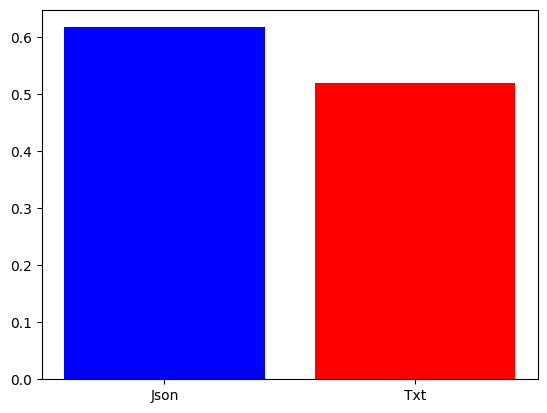

In [40]:
if __name__ == "__main__":

    book_ids = [43, 56]

    for book_id in book_ids:
        if already_downloaded(book_id):   
            print(f"[SKIP] {book_id} was already downloaded")
            continue

        try:
            res = download_book(book_id)
            if res:
                header_file, body_file = res
                register_in_control(book_id, header_file, body_file)
            else:
                register_in_control(book_id, "-", "-", state="FAILED")
        except Exception as e:
            print(f"[ERROR] Failed downloading {book_id}: {e}")
            register_in_control(book_id, "-", "-", state="FAILED")
    word = "love"
    start = time.time()
    inverted_index_strategy1 = build_inverted_index1()
    save_inverted_index(inverted_index_strategy1)
    results = inverted_index_strategy1.get(word.lower(), set())
    end = time.time()
    result_strategy_1 = end - start
    print(f"Results for '{word}': {results}")
    print("[OK] Inverted index strategy 1")
    print(f"Strategy 1 time '{result_strategy_1}'")
    
    start2= time.time()
    inverted_index_strategy2 = build_inverted_index2()
    save_inverted_index_txt(inverted_index_strategy2)
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    results2 = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith(f"{word.lower()}:"):
                ids_str = line.split(":")[1].strip()
                results2 = set(map(int, ids_str.split(","))) if ids_str else set()
                break

    print(f"Results for '{word}' [txt search]: {results2}")
    end2 = time.time()
    result_strategy_2 = end2 - start2
    print("[OK] Inverted index strategy 2")
    print(f"Strategy 2 time '{result_strategy_2}'")

    plt.bar(["Json", "Txt"] , [result_strategy_1, result_strategy_2], color=["blue", "red"])

# Compare index construction time

In [41]:
start = time.time()
inverted_index_json = build_inverted_index1()
end = time.time()
print(f"Strategy JSON build time: {end - start:.2f} sec")
start = time.time()
inverted_index_txt = build_inverted_index2()
end = time.time()
print(f"Strategy TXT build time: {end - start:.2f} sec")

Strategy JSON build time: 0.47 sec
Strategy TXT build time: 0.44 sec


# Compare search time

In [42]:
queries = ["love", "pride", "her", "mind"]

start = time.time()
for q in queries:
    results = inverted_index_json.get(q.lower(), set())
end = time.time()
print(f"JSON search time: {end - start:.4f} sec")

start = time.time()
txt_path = DATAMARTS_PATH / "inverted_index.txt"
for q in queries:
    results_txt = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith(f"{q.lower()}:"):
                ids_str = line.split(":")[1].strip()
                results_txt = set(map(int, ids_str.split(","))) if ids_str else set()
                break
end = time.time()
print(f"TXT search time: {end - start:.4f} sec")

JSON search time: 0.0000 sec
TXT search time: 0.0305 sec


# Compare memory usage

In [43]:
size_json = sys.getsizeof(inverted_index_json)
print(f"JSON index memory size: {size_json / 1024:.2f} KB")

size_txt = sys.getsizeof(inverted_index_txt)
print(f"TXT index memory size: {size_txt / 1024:.2f} KB")

JSON index memory size: 938.76 KB
TXT index memory size: 938.76 KB


# Compare disc size

In [44]:
json_file = DATAMARTS_PATH / "inverted_index.json"
txt_file  = DATAMARTS_PATH / "inverted_index.txt"

print(f"JSON file size: {json_file.stat().st_size / 1024:.2f} KB")
print(f"TXT file size: {txt_file.stat().st_size / 1024:.2f} KB")

JSON file size: 1158.23 KB
TXT file size: 514.44 KB


[SKIP] 43 was already downloaded
[SKIP] 84 was already downloaded
[OK] 98 -> datalake\20251007\21\98.header.txt / datalake\20251007\21\98.body.txt
[SKIP] 1342 was already downloaded
[OK] 2701 -> datalake\20251007\21\2701.header.txt / datalake\20251007\21\2701.body.txt
[OK] 514 -> datalake\20251007\21\514.header.txt / datalake\20251007\21\514.body.txt
[OK] 43 -> saved in datalake_alpha\R
[OK] 84 -> saved in datalake_alpha\M
[OK] 98 -> saved in datalake_alpha\C
[OK] 1342 -> saved in datalake_alpha\J
[OK] 2701 -> saved in datalake_alpha\H
[OK] 514 -> saved in datalake_alpha\L
 COMPARACIÓN DE DATALAKES
----------------------------
Por fecha/hora:  2 carpetas, 16 archivos, 3.724 s
Por autor:       21 carpetas, 604 archivos, 6.713 s


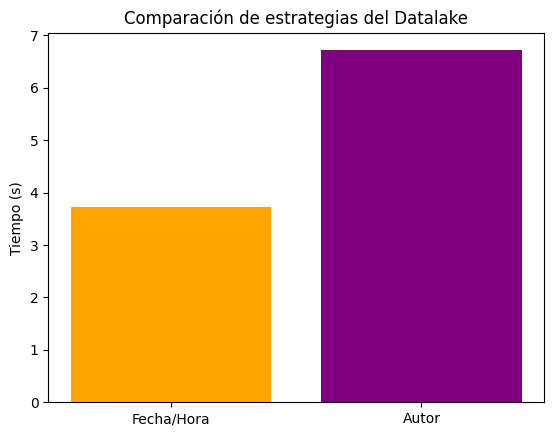

In [45]:
def count_files_and_folders(base_path: str):
    total_files = 0
    total_dirs = 0
    for root, dirs, files in os.walk(base_path):
        total_files += len(files)
        total_dirs += len(dirs)
    return total_dirs, total_files

def compare_datalakes(book_ids):
    start1 = time.time()
    for book_id in book_ids:
        download_book(book_id)
    end1 = time.time()
    time_date = end1 - start1
    dirs1, files1 = count_files_and_folders("datalake")
    start2 = time.time()
    for book_id in book_ids:
        download_book_alpha(book_id)
    end2 = time.time()
    time_alpha = end2 - start2
    dirs2, files2 = count_files_and_folders("datalake_alpha")

    print(" COMPARACIÓN DE DATALAKES")
    print("----------------------------")
    print(f"Por fecha/hora:  {dirs1} carpetas, {files1} archivos, {time_date:.3f} s")
    print(f"Por autor:       {dirs2} carpetas, {files2} archivos, {time_alpha:.3f} s")

    plt.bar(["Fecha/Hora", "Autor"], [time_date, time_alpha], color=["orange", "purple"])
    plt.ylabel("Tiempo (s)")
    plt.title("Comparación de estrategias del Datalake")
    plt.show()

compare_datalakes([43, 84, 98, 1342, 2701, 514])


In [46]:
for book_id in range(1, 328):
    try:
        download_book_alpha(book_id)  
    except Exception as e:
        print(f"[ERROR] Libro {book_id}: {e}")

[OK] 1 -> saved in datalake_alpha\T
[OK] 2 -> saved in datalake_alpha\U
[OK] 3 -> saved in datalake_alpha\J
[OK] 4 -> saved in datalake_alpha\A
[OK] 5 -> saved in datalake_alpha\U
[OK] 6 -> saved in datalake_alpha\P
[OK] 7 -> saved in datalake_alpha\U
[OK] 8 -> saved in datalake_alpha\A
[OK] 9 -> saved in datalake_alpha\A
[OK] 10 -> saved in datalake_alpha\U
[OK] 11 -> saved in datalake_alpha\L
[OK] 12 -> saved in datalake_alpha\L
[OK] 13 -> saved in datalake_alpha\L
[OK] 14 -> saved in datalake_alpha\U
[OK] 15 -> saved in datalake_alpha\H
[OK] 16 -> saved in datalake_alpha\J
[OK] 17 -> saved in datalake_alpha\J
[OK] 18 -> saved in datalake_alpha\A
[OK] 19 -> saved in datalake_alpha\H
[OK] 20 -> saved in datalake_alpha\J
[OK] 21 -> saved in datalake_alpha\A
[OK] 22 -> saved in datalake_alpha\P
[OK] 23 -> saved in datalake_alpha\F
[OK] 24 -> saved in datalake_alpha\W
[OK] 25 -> saved in datalake_alpha\U
[OK] 26 -> saved in datalake_alpha\J
[OK] 27 -> saved in datalake_alpha\T
[OK] 28 ->

SQLite - Insert: 0.0099s | Query: 0.000000s | Rows: 1
TinyDB - Insert: 0.0000s | Query: 0.000000s | Rows: 1
Files → datamarts/metadata_sqlite.db | datamarts/metadata_tinydb.json


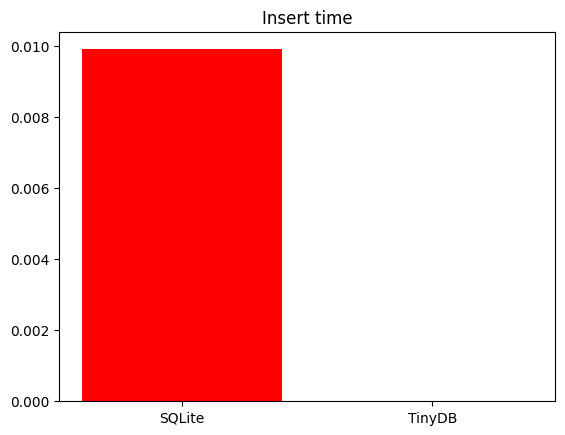

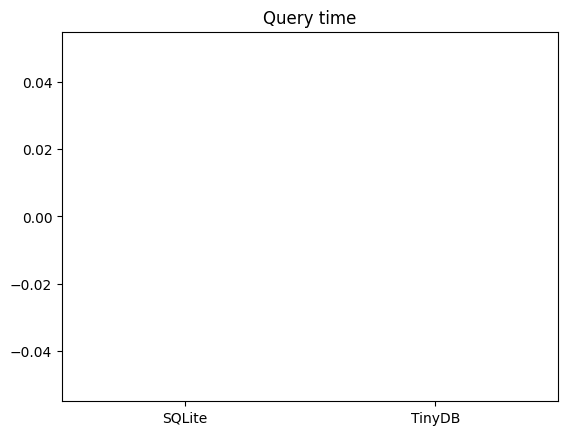

In [51]:
import sqlite3, random, os
from tinydb import TinyDB, Query

os.makedirs("datamarts", exist_ok=True)

random.seed(42)
sample_metadata = [
    {
        "book_id": i,
        "title": f"Book Title {i}",
        "author": random.choice(["Jane Austen", "Mark Twain", "Daniel Defoe", "Charles Dickens"]),
        "language": random.choice(["en", "es", "fr"]),
    }
    for i in range(1, 301)
]

def test_sqlite(metadata_list):
    db_path = "datamarts/metadata_sqlite.db"
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    cur.execute("""
        CREATE TABLE IF NOT EXISTS books (
            book_id INTEGER PRIMARY KEY,
            title TEXT,
            author TEXT,
            language TEXT
        )
    """)
    cur.execute("DELETE FROM books")
    conn.commit()

    t0 = time.time()
    cur.executemany(
        "INSERT INTO books (book_id, title, author, language) VALUES (:book_id, :title, :author, :language)",
        metadata_list
    )
    conn.commit()
    t1 = time.time()

    search_title = "Book Title 150"
    q0 = time.time()
    cur.execute("SELECT * FROM books WHERE title = ?", (search_title,))
    rows = cur.fetchall()
    q1 = time.time()

    conn.close()

    return {
        "insert_time": t1 - t0,
        "query_time": q1 - q0,
        "query_results": len(rows),
        "db_path": db_path
    }

def test_tinydb(metadata_list):
    tiny_path = "datamarts/metadata_tinydb.json"
    db = TinyDB(tiny_path)
    db.drop_tables()  

    t0 = time.time()
    db.insert_multiple(metadata_list)
    t1 = time.time()

    search_title = "Book Title 150"
    q = Query()
    q0 = time.time()
    rows = db.search(q.title == search_title)
    q1 = time.time()
    db.close()

    return {
        "insert_time": t1 - t0,
        "query_time": q1 - q0,
        "query_results": len(rows),
        "db_path": tiny_path
    }

sqlite_results = test_sqlite(sample_metadata)
tinydb_results = test_tinydb(sample_metadata)

print(f"SQLite - Insert: {sqlite_results['insert_time']:.4f}s | Query: {sqlite_results['query_time']:.6f}s | Rows: {sqlite_results['query_results']}")
print(f"TinyDB - Insert: {tinydb_results['insert_time']:.4f}s | Query: {tinydb_results['query_time']:.6f}s | Rows: {tinydb_results['query_results']}")
print(f"Files → {sqlite_results['db_path']} | {tinydb_results['db_path']}")

labels = ["SQLite", "TinyDB"]
insert_times = [sqlite_results["insert_time"], tinydb_results["insert_time"]]
query_times  = [sqlite_results["query_time"],  tinydb_results["query_time"]]

plt.title("Insert time")
plt.bar(labels, insert_times, color = ["red", "blue"])
plt.show()

plt.title("Query time")
plt.bar(labels, query_times, color = ["red", "blue"])
plt.show()